# Multi-armed bandits

## imports

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from abc import ABC, abstractmethod

matplotlib.use('Agg')
%matplotlib inline

## Código-base do caça-níquel

A classe implementa um multiarmed bandit cuja recompensa média de cada braço é sorteada. Além disso, quando o braço é puxado (get_reward), a recompensa retornada é sorteada com uma gaussiana.

In [3]:
class Environment:
    def __init__(self, k_arm=10, base_reward=0., seed=None):
        self.k = k_arm
        self.base_reward = base_reward
        self.seed = seed
        self.reset()

    def reset(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        # Real reward for each action
        self.q_true = np.random.randn(self.k) + self.base_reward
        self.best_action = np.argmax(self.q_true)

    def get_reward(self, action):
        # Generate the reward under N(real reward, 1)
        return np.random.randn() + self.q_true[action]

## Agentes

Cada agente representará uma política

### Classe abstrata do agente, representando a política

Você implementará cada política em uma subclasse diferente

In [7]:
class Agent(ABC):
    def __init__(self, k_arm=10, initial_estimate=0.):
        self.k = k_arm
        self.initial = initial_estimate
        self.reset()

    def reset(self):
        # Estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

    @abstractmethod
    def act(self):
        pass

    @abstractmethod
    def update(self, action, reward):
        pass

### Epsilon-greedy com estimativa pela média amostral

Implemente o agente epsilon-greedy que atualiza as estimativas de valor de uma ação pela média amostral (soma das recompensas recebidas naquela ação / #de tentativas naquela ação)

In [22]:
class EpsilonGreedySampleAverageAgent(Agent):
    def __init__(self, k_arm=10, epsilon=0.1, initial_estimate=0.):
            super().__init__(k_arm, initial_estimate)
            self.epsilon = epsilon
            self.action_count = np.zeros(self.k)  

    def act(self):
        if np.random.rand() < self.epsilon:
           
            return np.random.randint(self.k)
        
        return np.argmax(self.q_estimation)

    def update(self, action, reward):
        
        self.action_count[action] += 1

        
        alpha = 1.0 / self.action_count[action]

        #
        self.q_estimation[action] += alpha * (reward - self.q_estimation[action])


### Epsilon-greedy com estimativa pela média amostral

In [23]:
class EpsilonGreedySampleAverageAgent(Agent):
    def __init__(self, k_arm=10, epsilon=0.1, initial_estimate=0.):
        super().__init__(k_arm, initial_estimate)
        self.epsilon = epsilon
        self.action_count = np.zeros(self.k)  
    
    def reset(self):
        super().reset()
        self.action_count = np.zeros(self.k)

    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)
        return np.argmax(self.q_estimation)

    def update(self, action, reward):
        self.action_count[action] += 1
        alpha = 1.0 / self.action_count[action]
        self.q_estimation[action] += alpha * (reward - self.q_estimation[action])

        


### Epsilon-greedy com atualização de passo constante

In [ ]:
class EpsilonGreedyConstantStepsizeAgent(Agent):
    def __init__(self, k_arm=10, epsilon=0.1, initial_estimate=0., step_size=0.1):
        super().__init__(k_arm, initial_estimate)
        self.epsilon = epsilon
        self.step_size = step_size

    def reset(self):
        super().reset()
        self.action_count = np.zeros(self.k)

    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)         
        return np.argmax(self.q_estimation)          

    def update(self, action, reward):
        self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])


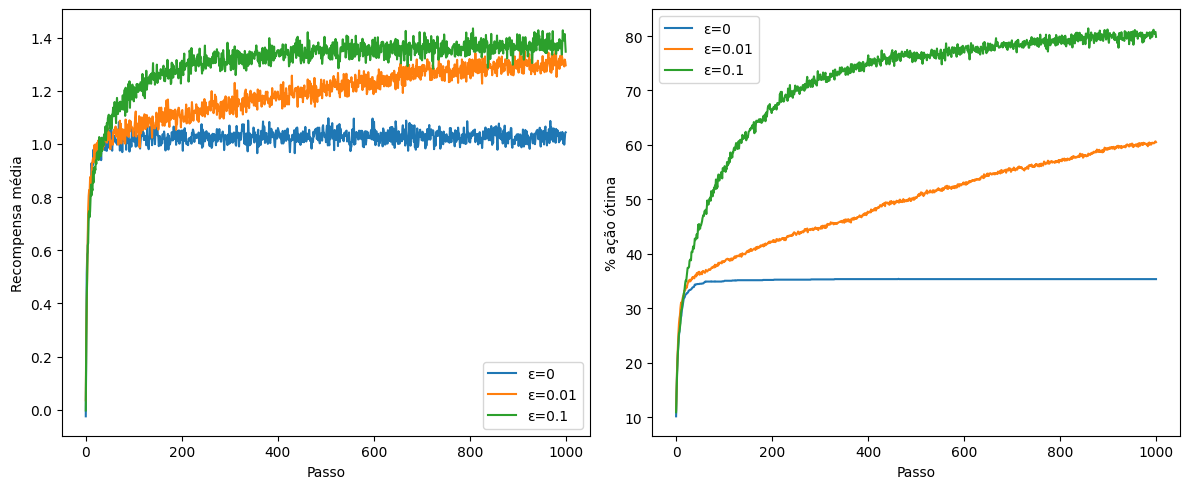

In [24]:
num_arms, num_steps, num_runs = 10, 1000, 2000
epsilon_values = [0, 0.01, 0.1]

def run_bandit_experiment(epsilon):
    rewards_per_step = np.zeros(num_steps)
    optimal_action_counts = np.zeros(num_steps)

    for run in range(num_runs):
        env = Environment(k_arm=num_arms)
        agent = EpsilonGreedySampleAverageAgent(k_arm=num_arms, epsilon=epsilon)

        for step in range(num_steps):
            action = agent.act()
            reward = env.get_reward(action)
            agent.update(action, reward)

            rewards_per_step[step] += reward
            optimal_action_counts[step] += (action == env.best_action)

    avg_rewards = rewards_per_step / num_runs
    optimal_action_rate = (optimal_action_counts / num_runs) * 100
    return avg_rewards, optimal_action_rate

plt.figure(figsize=(12,5))
for epsilon in epsilon_values:
    avg_rewards, optimal_rate = run_bandit_experiment(epsilon)
    plt.subplot(1,2,1)
    plt.plot(avg_rewards, label=f"ε={epsilon}")
    plt.subplot(1,2,2)
    plt.plot(optimal_rate, label=f"ε={epsilon}")

plt.subplot(1,2,1)
plt.xlabel("Passo"); plt.ylabel("Recompensa média"); plt.legend()
plt.subplot(1,2,2)
plt.xlabel("Passo"); plt.ylabel("% ação ótima"); plt.legend()
plt.tight_layout()
plt.show()

### Agente com atualização por subida de gradiente

In [ ]:
class GradientAgent(Agent):
    def __init__(self, k_arm=10, step_size=0.1, initial_estimate=0., use_baseline=True, temperature=1.0):
        super().__init__(k_arm, initial_estimate)
        self.step_size = step_size
        self.use_baseline = use_baseline
        self.temperature = temperature

    def reset(self):
        super().reset()  
        self.preferences = np.zeros(self.k)
        self.avg_reward = 0.0
        self.t = 0
        self.action_prob = np.full(self.k, 1.0 / self.k)

    def _softmax(self):
        z = (self.preferences / self.temperature) - np.max(self.preferences / self.temperature)
        e = np.exp(z)
        return e / e.sum()

    def act(self):
        self.action_prob = self._softmax()
        return np.random.choice(self.k, p=self.action_prob)

    def update(self, action, reward):
        self.t += 1
        baseline = self.avg_reward if self.use_baseline else 0.0
        if self.use_baseline:
            self.avg_reward += (reward - self.avg_reward) / self.t
        grad = -self.action_prob
        grad[action] += 1.0
        self.preferences += self.step_size * (reward - baseline) * grad


## Código para executar uma simulação

Para usar, você deve informar quantas execuções independentes fará (runs), quantas iterações/tentativas haverá em cada execução (time), a lista de agentes (agents) e o multi-armed bandit (environment). A simulação retorna um vetor 2D (agentes x iterações) contendo a média de vezes que a melhor ação foi selecionada em cada iteração e outro vetor 2D (agentes x iterações) de recompensas médias por iteração.

In [13]:
def simulate(runs, time, agents, environment):
    rewards = np.zeros((len(agents), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, agent in enumerate(agents):
        for r in trange(runs):
            environment.reset()
            agent.reset()
            for t in range(time):
                action = agent.act()
                reward = environment.get_reward(action)
                agent.update(action, reward)
                rewards[i, r, t] = reward
                if action == environment.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

### Exemplo de simulação, gerando um gráfico

100%|██████████| 50/50 [00:00<00:00, 710.62it/s]


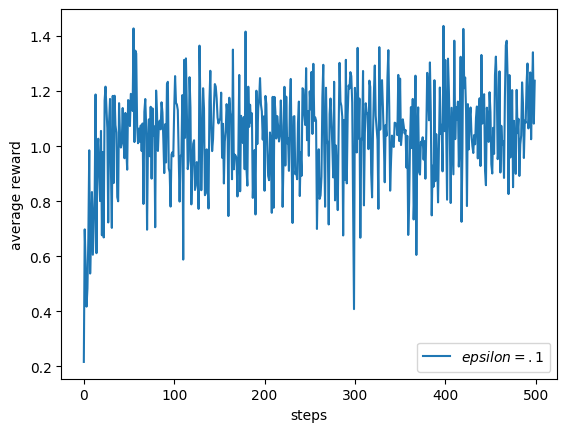

In [12]:
def example_simulation(runs=50, time=500):
    env = Environment(k_arm=10)
    agents = [EpsilonGreedySampleAverageAgent(epsilon=0.1, initial_estimate=0)]

    best_action_counts, rewards = simulate(runs, time, agents, env)

    plt.plot(rewards[0], label='$epsilon = .1$')
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()

    plt.show()

example_simulation()

## Tarefas

1. Implementar as subclasses dos agentes
2. Em um multi-armed bandit com 10 alavancas e recompensa base de 0, gerar um gráfico comparando as políticas a seguir. Cada política deve ser executada 2000 vezes com 1000 tentativas em cada vez.
  * epsilon-greedy atualizado com média amostral com epsilon=0
  * epsilon-greedy atualizado com média amostral com epsilon=0.1
  * epsilon-greedy atualizado com média amostral com epsilon=0.01
3. Em um multi-armed bandit com 10 alavancas e recompensa base de 0, gerar um gráfico comparando as políticas a seguir (use alpha=0.1 para os agentes que atualizam estimativas usando tamanho de passo constante). Cada política deve ser executada 2000 vezes com 1000 tentativas em cada vez.
  * epsilon-greedy atualizado com média amostral com epsilon=0.01
  * epsilon-greedy atualizado com tamanho de passo constante com epsilon=0.01
  * gradiente
4. Crie uma nova classe modificando Environment, de forma a criar um multi-armed bandit não-estacionário (que muda ao longo do tempo). Em especial, faça os q_true iniciarem iguais (e.g. 0) e, a cada passo (step), cada um muda sendo somado a um valor sorteado por uma Normal(0,0.01). Reexecute a comparação da Tarefa 3, porém com 1000 repetições de 10 mil tentativas para cada agente.

In [ ]:
## Tarefa 2

In [16]:
def plot_bandit_results(mean_best_action_counts, mean_rewards, labels, time):
    steps = np.arange(time)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    for i, lab in enumerate(labels):
        plt.plot(steps, mean_rewards[i], label=lab)
    plt.xlabel("Passo"); plt.ylabel("Recompensa média"); plt.legend()

    plt.subplot(1,2,2)
    for i, lab in enumerate(labels):
        plt.plot(steps, mean_best_action_counts[i] * 100, label=lab)
    plt.xlabel("Passo"); plt.ylabel("% ação ótima"); plt.legend()

    plt.tight_layout()
    plt.show()

100%|██████████| 2000/2000 [00:05<00:00, 351.16it/s]


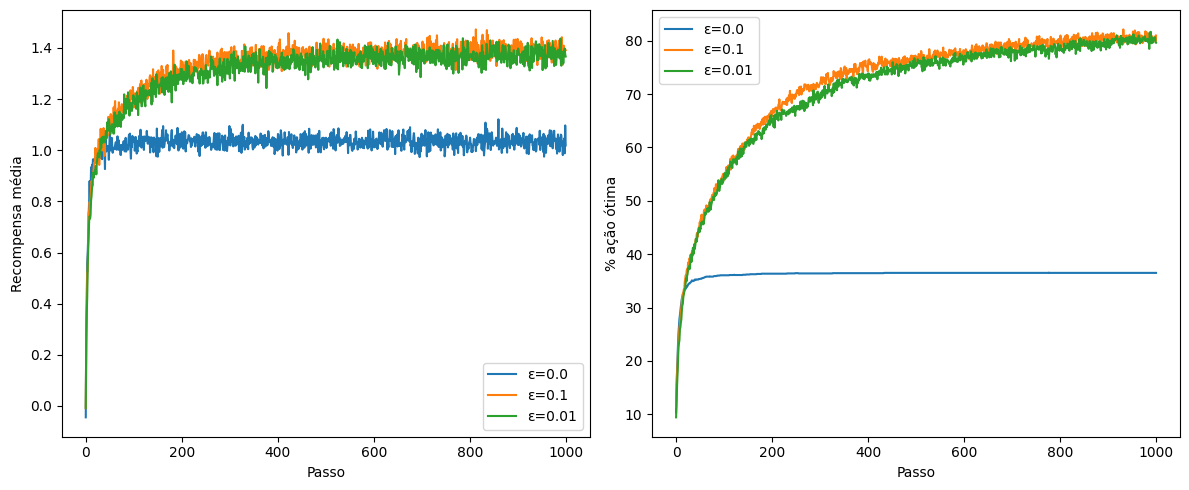

In [25]:
import numpy as np
import matplotlib.pyplot as plt


agents = [
    EpsilonGreedySampleAverageAgent(k_arm=10, epsilon=0.0),
    EpsilonGreedySampleAverageAgent(k_arm=10, epsilon=0.1),
    EpsilonGreedySampleAverageAgent(k_arm=10, epsilon=0.1),
]


env = Environment(k_arm=10)

# simulação
runs, time = 2000, 1000
mean_best_action_counts, mean_rewards = simulate(runs, time, agents, env)


labels = [r"ε=0.0", r"ε=0.1", r"ε=0.01"]
steps = np.arange(time)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for i, lab in enumerate(labels):
    plt.plot(steps, mean_rewards[i], label=lab)
plt.xlabel("Passo"); plt.ylabel("Recompensa média"); plt.legend()

plt.subplot(1,2,2)
for i, lab in enumerate(labels):
    plt.plot(steps, mean_best_action_counts[i] * 100, label=lab)
plt.xlabel("Passo"); plt.ylabel("% ação ótima"); plt.legend()

plt.tight_layout()
plt.show()










No longo prazo, as políticas com ε > 0 acumulam mais recompensa, porque a exploração evita que o agente fique preso em escolhas ruins. Entre elas, ε = 0.1 e ε = 0.01 têm desempenho semelhante, muito superior ao caso determinístico com ε = 0

## Tarefa 3
o ε-greedy com passo constante é o melhor, seguido pelo ε-greedy com média amostral, enquanto o gradiente foi o pior nesse cenário

100%|██████████| 2000/2000 [00:53<00:00, 37.60it/s]


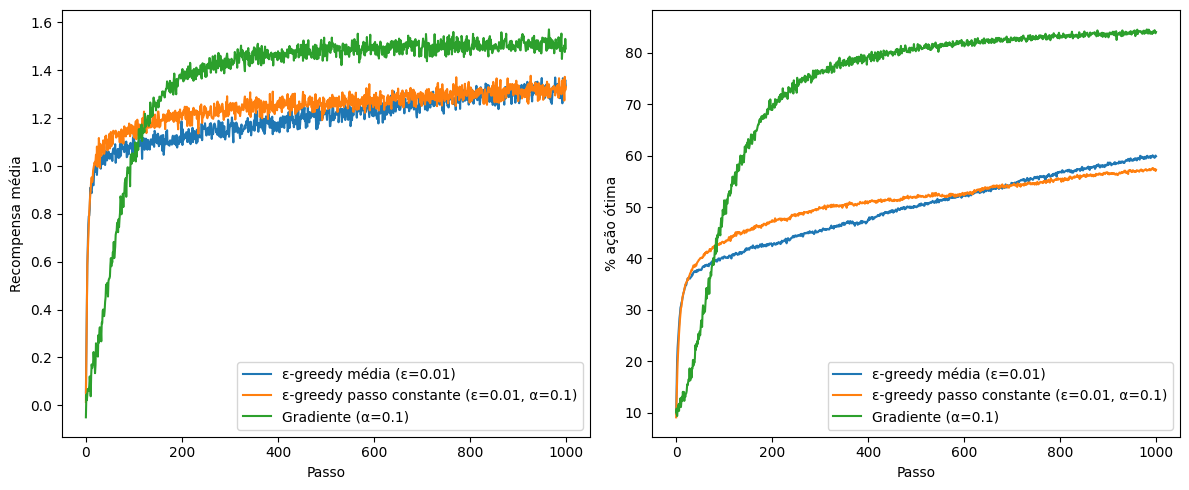

In [26]:
agents = [
    EpsilonGreedySampleAverageAgent(k_arm=10, epsilon=0.01),
    EpsilonGreedyConstantStepsizeAgent(k_arm=10, epsilon=0.01, step_size=0.1),
    GradientAgent(k_arm=10, step_size=0.1),
]

env = Environment(k_arm=10)
runs, time = 2000, 1000

mean_best_action_counts, mean_rewards = simulate(runs, time, agents, env)

labels = [
    r"ε-greedy média (ε=0.01)",
    r"ε-greedy passo constante (ε=0.01, α=0.1)",
    r"Gradiente (α=0.1)"
]

plot_bandit_results(mean_best_action_counts, mean_rewards, labels, time)

## Tarefa 4

In [14]:
class NonStationaryEnvironment(Environment):
    def __init__(self, k_arm=10, base_reward=0., seed=None, drift_std=0.01):
        super().__init__(k_arm=k_arm, base_reward=base_reward, seed=seed)
        self.drift_std = drift_std

    def reset(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        self.q_true = np.zeros(self.k) + self.base_reward
        self.best_action = np.argmax(self.q_true)

    def get_reward(self, action):
        self.q_true += np.random.normal(0.0, self.drift_std, size=self.k)
        self.best_action = np.argmax(self.q_true)
        return np.random.randn() + self.q_true[action]

100%|██████████| 1000/1000 [04:55<00:00,  3.38it/s]


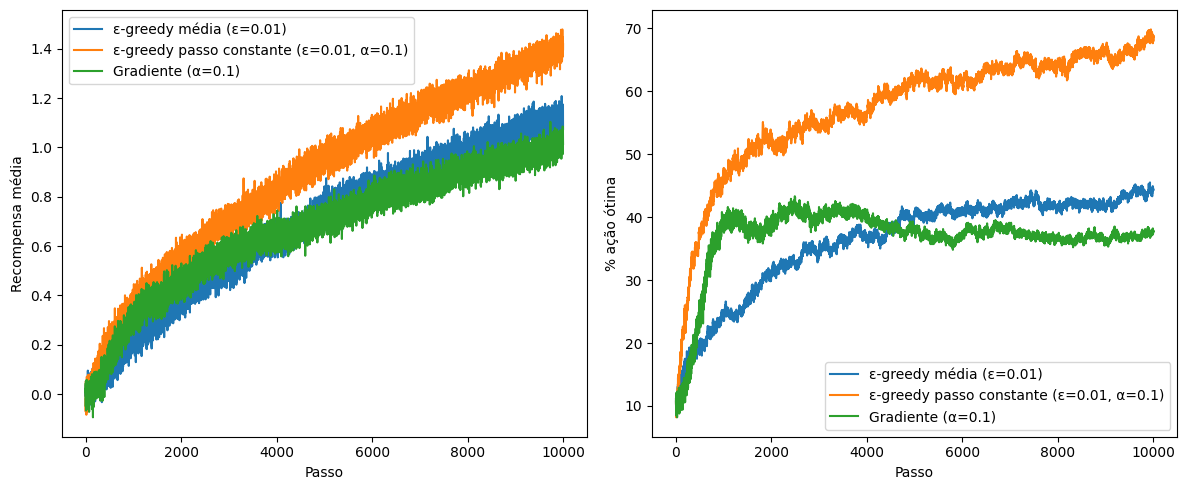

In [27]:
agents = [
    EpsilonGreedySampleAverageAgent(k_arm=10, epsilon=0.01),
    EpsilonGreedyConstantStepsizeAgent(k_arm=10, epsilon=0.01, step_size=0.1),
    GradientAgent(k_arm=10, step_size=0.1),
]

env_ns = NonStationaryEnvironment(k_arm=10, base_reward=0.0, drift_std=0.01)

runs, time = 1000, 10_000
mean_best_action_counts, mean_rewards = simulate(runs, time, agents, env_ns)

labels = [
    r"ε-greedy média (ε=0.01)",
    r"ε-greedy passo constante (ε=0.01, α=0.1)",
    r"Gradiente (α=0.1)",
]

plot_bandit_results(mean_best_action_counts, mean_rewards, labels, time)

No ambiente não-estacionário, o ε-greedy com média amostral apresentou o pior desempenho, pois não conseguiu se adaptar às mudanças ao longo do tempo. O ε-greedy com passo constante foi o mais eficiente, alcançando as maiores recompensas e maior percentual de ações ótimas. Já o método do gradiente obteve um desempenho intermediário, ficando entre as duas estratégias.